In [1]:
# Détection de maladies

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [3]:
train_folder = "../input/plant-disease-recognition-dataset/Train/Train"
test_folder = "../input/plant-disease-recognition-dataset/Test/Test"
val_folder= "../input/plant-disease-recognition-dataset/Validation/Validation"

In [4]:
def no_of_files(rootdir):
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
no_of_files(os.path.join(test_folder))

There are 50 files in Healthy
There are 50 files in Rust
There are 50 files in Powdery


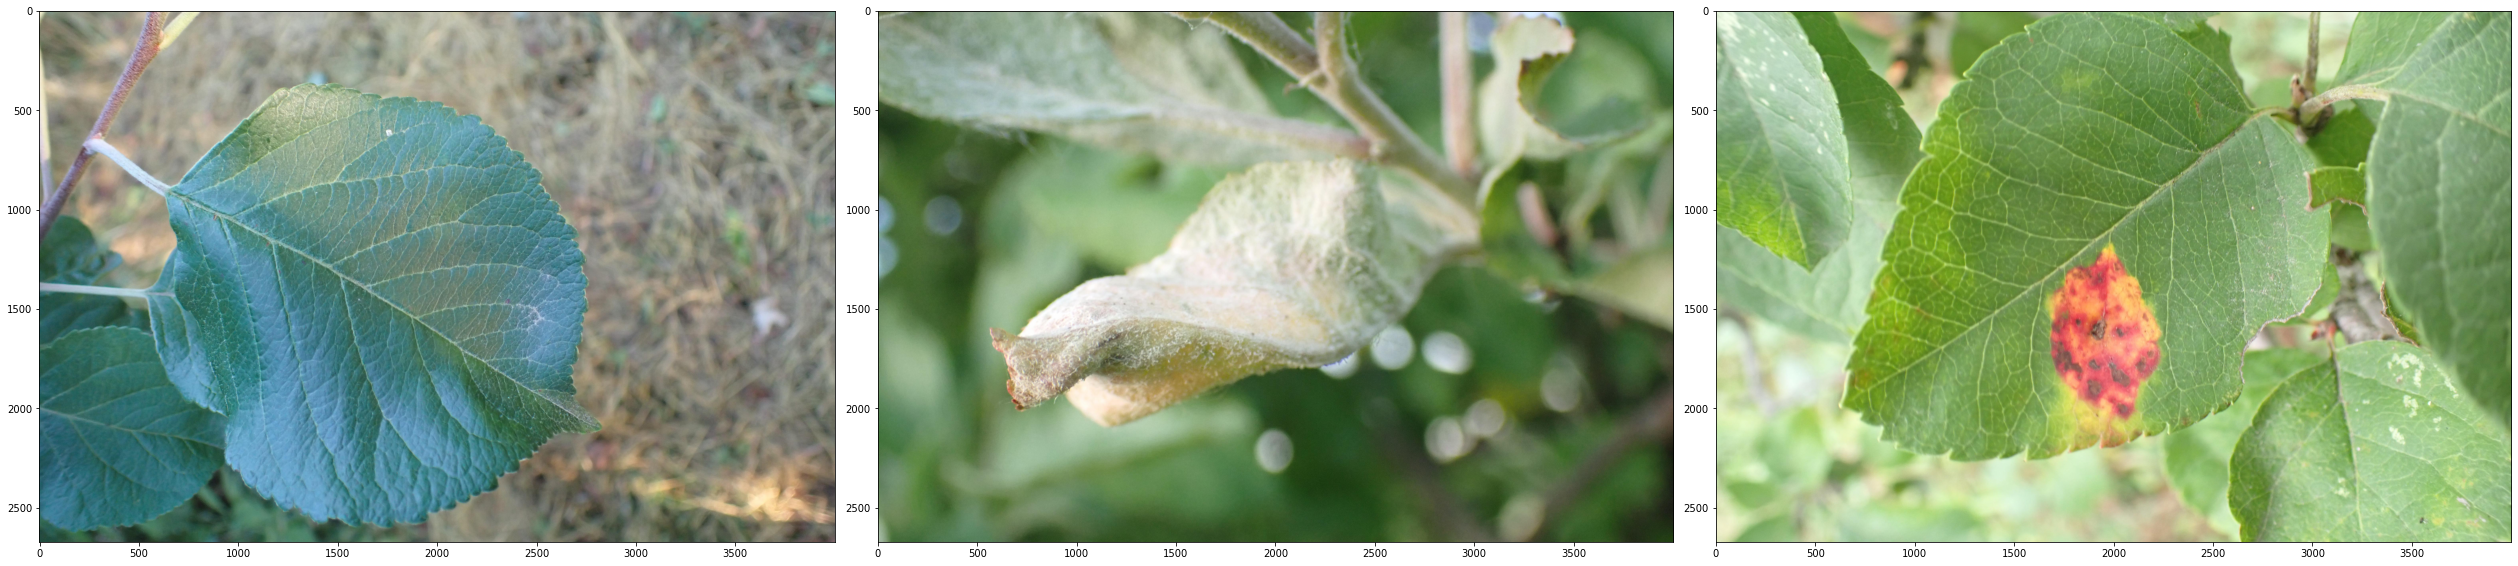

In [5]:
images = []

for selected_folder in sorted(os.listdir(train_folder)):
    cell = os.listdir(train_folder + '/' + selected_folder)
    folder_selected = np.random.choice(cell)
    images.append(os.path.join(train_folder,selected_folder,folder_selected))
                                     
fig=plt.figure(1, figsize=(70, 50))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(6, 6, subplot+1)
    plt.imshow(imgs)
    
plt.tight_layout()

In [6]:
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [7]:
training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 48, 
    class_mode = 'categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [8]:
modelr=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in modelr.layers:
    layer.trainable=False

171327488/171317808 [==============================] - 7s 0us/step


In [9]:
model=Sequential()
model.add(modelr)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [10]:
optimizer=tf.keras.optimizers.Adam(lr=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [11]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
        
)

Epoch 1/15
28/28 [==============================] - 232s 8s/step - loss: 0.3439 - accuracy: 0.8699 - val_loss: 2.3793 - val_accuracy: 0.8200
Epoch 2/15
28/28 [==============================] - 197s 7s/step - loss: 0.0728 - accuracy: 0.9796 - val_loss: 0.6324 - val_accuracy: 0.8800
Epoch 3/15
28/28 [==============================] - 199s 7s/step - loss: 0.0247 - accuracy: 0.9939 - val_loss: 0.4809 - val_accuracy: 0.8933
Epoch 4/15
28/28 [==============================] - 203s 7s/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.4253 - val_accuracy: 0.9000
Epoch 5/15
28/28 [==============================] - 197s 7s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.3812 - val_accuracy: 0.9000
Epoch 6/15
28/28 [==============================] - 192s 7s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3764 - val_accuracy: 0.9067
Epoch 7/15
28/28 [==============================] - 194s 7s/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.3660 - val_accuracy: 0.9133
Epoch 8/15
28

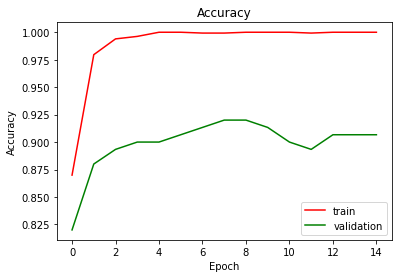

In [12]:
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='lower right')

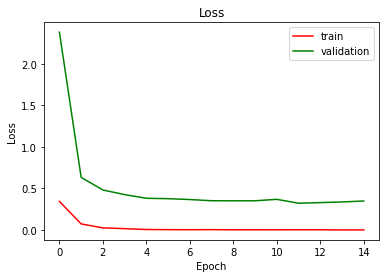

In [13]:
plt.plot(history.history['loss'],c='red')
plt.plot(history.history['val_loss'],c='green')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')

In [14]:
model.evaluate(test_set)

4/4 [==============================] - 18s 4s/step - loss: 0.3484 - accuracy: 0.9067


[0.34842750430107117, 0.9066666960716248]

In [15]:
dic=training_set.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    predict_x=model.predict(test_set) 
    classes_x=np.argmax(predict_x,axis=1)
    print ('Pridicted Class',icd[classes_x[0]])

In [16]:
print(dic)

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}


Pridicted Class Powdery


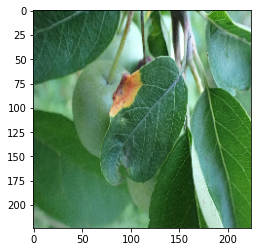

In [17]:
test_img='../input/plant-disease-recognition-dataset/Test/Test/Rust/849a8d127bfaeb21.jpg'
pic=load_img(test_img,target_size=(224,224,3))
plt.imshow(pic)
output(test_img)

In [18]:
!mkdir -p saved_model
model.save('saved_model/my_model')


In [19]:
import os


In [20]:
os.chdir("/kaggle/working/saved_model/my_model")

In [21]:
from IPython.display import FileLink
%ls

assets/  keras_metadata.pb  saved_model.pb  variables/


In [22]:
!pip install zip_files


In [23]:
!zip-folder --auto-root --outfile /kaggle/working/run.zip /kaggle/working/

In [24]:
os.chdir("/kaggle/working/")
FileLink(r'run.zip')

/kaggle/working/run.zip

<a href="/kaggle/working/run.zip"> Download File </a>